# Importing the Required Libraries

In [ ]:
# Install the datasets library if not already installed
# !pip install datasets

# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Loading the Transactional Dataset

In [ ]:
# Step 2: Load the dataset
df = pd.read_csv("hf://datasets/dazzle-nu/CIS435-CreditCardFraudDetection/fraudTrain.csv")

# Display the first few rows
print(df.head())

   Unnamed: 0 trans_date_trans_time        cc_num  \
0           0           1/1/19 0:00  2.703190e+15   
1           1           1/1/19 0:00  6.304230e+11   
2           2           1/1/19 0:00  3.885950e+13   
3           3           1/1/19 0:01  3.534090e+15   
4           4           1/1/19 0:03  3.755340e+14   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ... city_pop  \
0    Banks      F                561 Perry Cove  ...     3495   
1     Gill      F  43039 Riley Greens Suite 393  ...      149   
2  Sanchez      M      594 White Da

In [ ]:
# Reduce the dataset to 50,000 randomly sampled rows
df_reduced = df.sample(n=100000, random_state=42).reset_index(drop=True)

# Confirm shape
print("Reduced dataset shape:", df_reduced.shape)

Reduced dataset shape: (100000, 25)


# Explore Dataset Structure and Summary

In [ ]:
# Data shape
print("Shape of the dataset:", df_reduced.shape)

# Number of rows (length)
print("Total number of records:", len(df_reduced))

# Column names
print("\nColumns in the dataset:")
print(df_reduced.columns.tolist())

# Data types and non-null counts
print("\nDataset info:")
print(df_reduced.info())

# First 5 rows
print("\nFirst 5 records:")
print(df_reduced.head())

Shape of the dataset: (100000, 25)
Total number of records: 100000

Columns in the dataset:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'Unnamed: 23', '6006']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   trans_date_trans_time  100000 non-null  object 
 2   cc_num                 100000 non-null  float64
 3   merchant               100000 non-null  object 
 4   category               100000 non-null  object 
 5   amt                    100000 non-null  float64
 6   first                  100000 non-null  object 
 7   last                   100000 

In [ ]:
# 1. Dataset shape and basic info
print("Dataset Shape:", df_reduced.shape)
print("Column Names:", df_reduced.columns.tolist())

# 2. Data types and null values
print("\nMissing Values Per Column:")
print(df_reduced.isnull().sum())

# 3. Summary statistics for numerical features
print("\nSummary Statistics (Numerical Features):")
print(df_reduced.describe())

# 4. Check class distribution (Fraud vs. Not Fraud)
print("\nClass Distribution (is_fraud):")
print(df_reduced['is_fraud'].value_counts())
print("\nClass Distribution (Percentages):")
print(df_reduced['is_fraud'].value_counts(normalize=True) * 100)

# 5. Drop completely empty or irrelevant columns
df_reduced = df_reduced.drop(columns=["Unnamed: 0", "Unnamed: 23", "6006"])
print("\nColumns after dropping irrelevant ones:")
print(df_reduced.columns.tolist())

Dataset Shape: (100000, 25)
Column Names: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'Unnamed: 23', '6006']

Missing Values Per Column:
Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat          

# Pre-processing

## Handling Missing or Null Values in the Dataset

In [ ]:
# Check for any remaining missing values
missing_values = df_reduced.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

print("\n No missing values found. Dataset is clean.")

Missing values per column:
Series([], dtype: int64)

 No missing values found. Dataset is clean.


## Encoding the Categorical Features Using Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying the original
df_encoded = df_reduced.copy()

# Drop columns not useful for modeling
df_encoded.drop(columns=['first', 'last', 'street', 'dob', 'cc_num',
                         'trans_num', 'trans_date_trans_time'], inplace=True)

# List of categorical columns to encode
categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']

# Apply Label Encoding to each
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Store encoder for possible inverse_transform

# Check the encoded data
print("\nEncoded dataset sample:")
print(df_encoded[categorical_cols + ['is_fraud']].head())

# Confirm data types
print("\nData types after encoding:")
print(df_encoded.dtypes)


Encoded dataset sample:
   merchant  category  gender  city  state  job  is_fraud
0       139         0       1   402     36  338         0
1       134         0       0   723     17  463         0
2       461         6       1   722     14  202         0
3       291         3       1   164     20  148         0
4       174        11       1   180     35  179         0

Data types after encoding:
merchant        int64
category        int64
amt           float64
gender          int64
city            int64
state           int64
zip             int64
lat           float64
long          float64
city_pop        int64
job             int64
unix_time       int64
merch_lat     float64
merch_long    float64
is_fraud        int64
dtype: object


## Normalizing the Numerical Features Using Min-Max

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Make a copy to avoid modifying original
df_scaled = df_encoded.copy()

# List of features to normalize (excluding 'is_fraud')
features_to_scale = df_scaled.drop(columns=['is_fraud']).columns.tolist()

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Confirm results
print("\nNormalized feature sample:")
print(df_scaled.head())

# Check value ranges (should be between 0 and 1)
print("\nFeature value ranges after Min-Max scaling:")
print(df_scaled[features_to_scale].agg(['min', 'max']))


Normalized feature sample:
   merchant  category       amt  gender      city  state       zip       lat  \
0  0.200867  0.000000  0.005078     1.0  0.469078   0.72  0.735816  0.350530   
1  0.193642  0.000000  0.004749     0.0  0.843641   0.34  0.415261  0.364954   
2  0.666185  0.461538  0.006265     1.0  0.842474   0.28  0.611209  0.438399   
3  0.420520  0.230769  0.005644     1.0  0.191365   0.40  0.205702  0.421496   
4  0.251445  0.846154  0.000352     1.0  0.210035   0.70  0.436088  0.452561   

       long  city_pop       job  unix_time  merch_lat  merch_long  is_fraud  
0  0.691754  0.000363  0.698347   0.770066   0.339496    0.680472         0  
1  0.813312  0.002346  0.956612   0.859809   0.381454    0.801370         0  
2  0.771440  0.000209  0.417355   0.834522   0.433979    0.761907         0  
3  0.888942  0.000207  0.305785   0.771090   0.420624    0.887696         0  
4  0.861235  0.016427  0.369835   0.649529   0.440697    0.845258         0  

Feature value ranges a

# EDA: Visualizing the Distribution of Fraud and Non-Fraud Transactions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

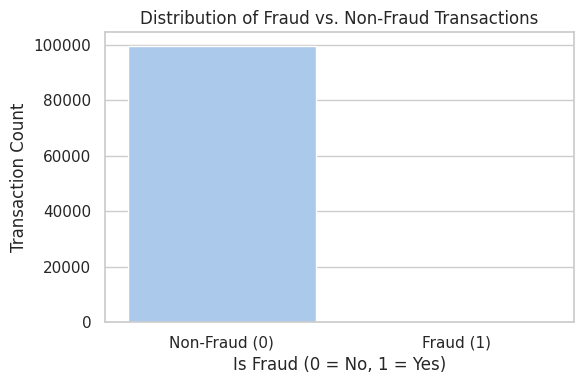

In [ ]:
# Countplot: Fraud vs Non-Fraud
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_scaled, palette='pastel')
plt.title("Distribution of Fraud vs. Non-Fraud Transactions")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("Transaction Count")
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

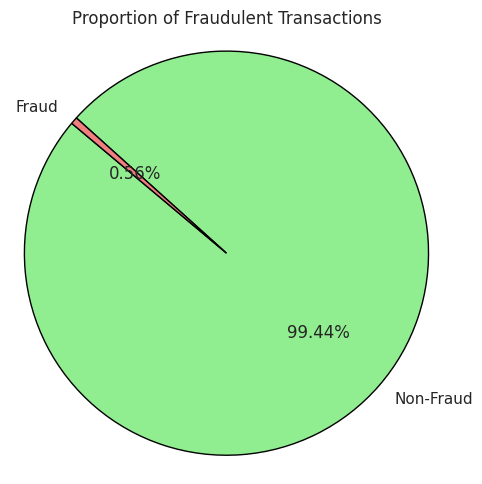

In [ ]:
# Pie Chart: Proportion of Fraud vs. Non-Fraud
fraud_counts = df_scaled['is_fraud'].value_counts()
labels = ['Non-Fraud', 'Fraud']
colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(5, 5))
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Proportion of Fraudulent Transactions")
plt.axis('equal')  # Equal aspect ratio ensures a perfect circle
plt.tight_layout()
plt.show()

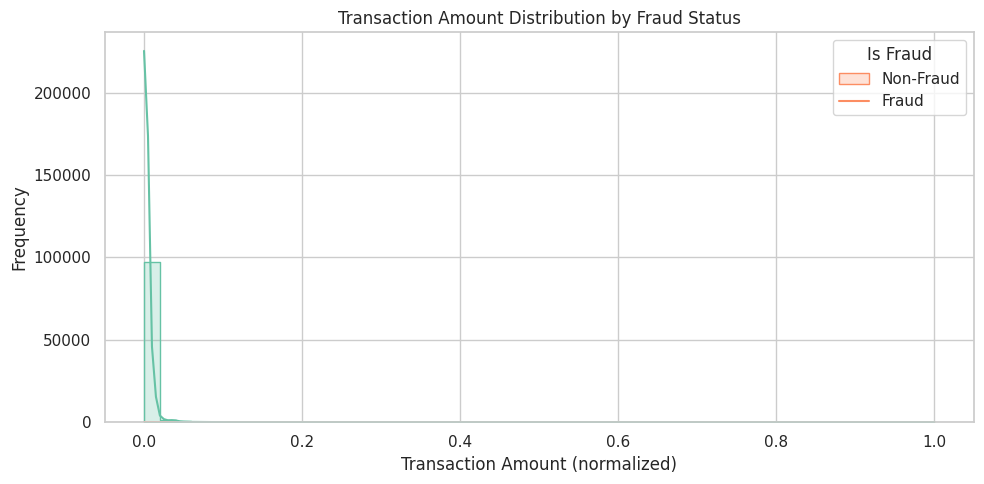

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_scaled, x='amt', hue='is_fraud', bins=50, kde=True, palette='Set2', element='step')
plt.title("Transaction Amount Distribution by Fraud Status")
plt.xlabel("Transaction Amount (normalized)")
plt.ylabel("Frequency")
plt.legend(title='Is Fraud', labels=['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

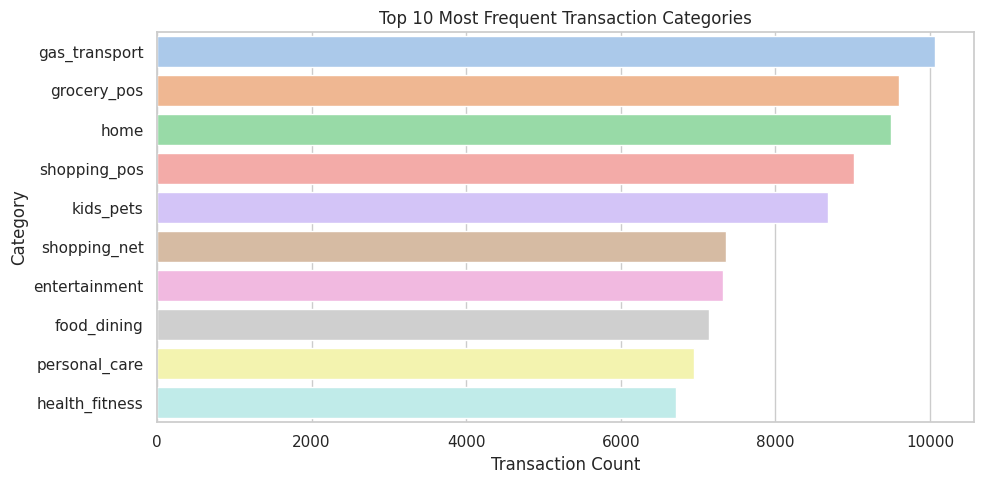

In [ ]:
# Map encoded category values back to strings
category_encoder = label_encoders['category']
df_scaled['category_name'] = category_encoder.inverse_transform(df_encoded['category'])

plt.figure(figsize=(10, 5))
sns.countplot(data=df_scaled, y='category_name', order=df_scaled['category_name'].value_counts().iloc[:10].index, palette='pastel')
plt.title("Top 10 Most Frequent Transaction Categories")
plt.xlabel("Transaction Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

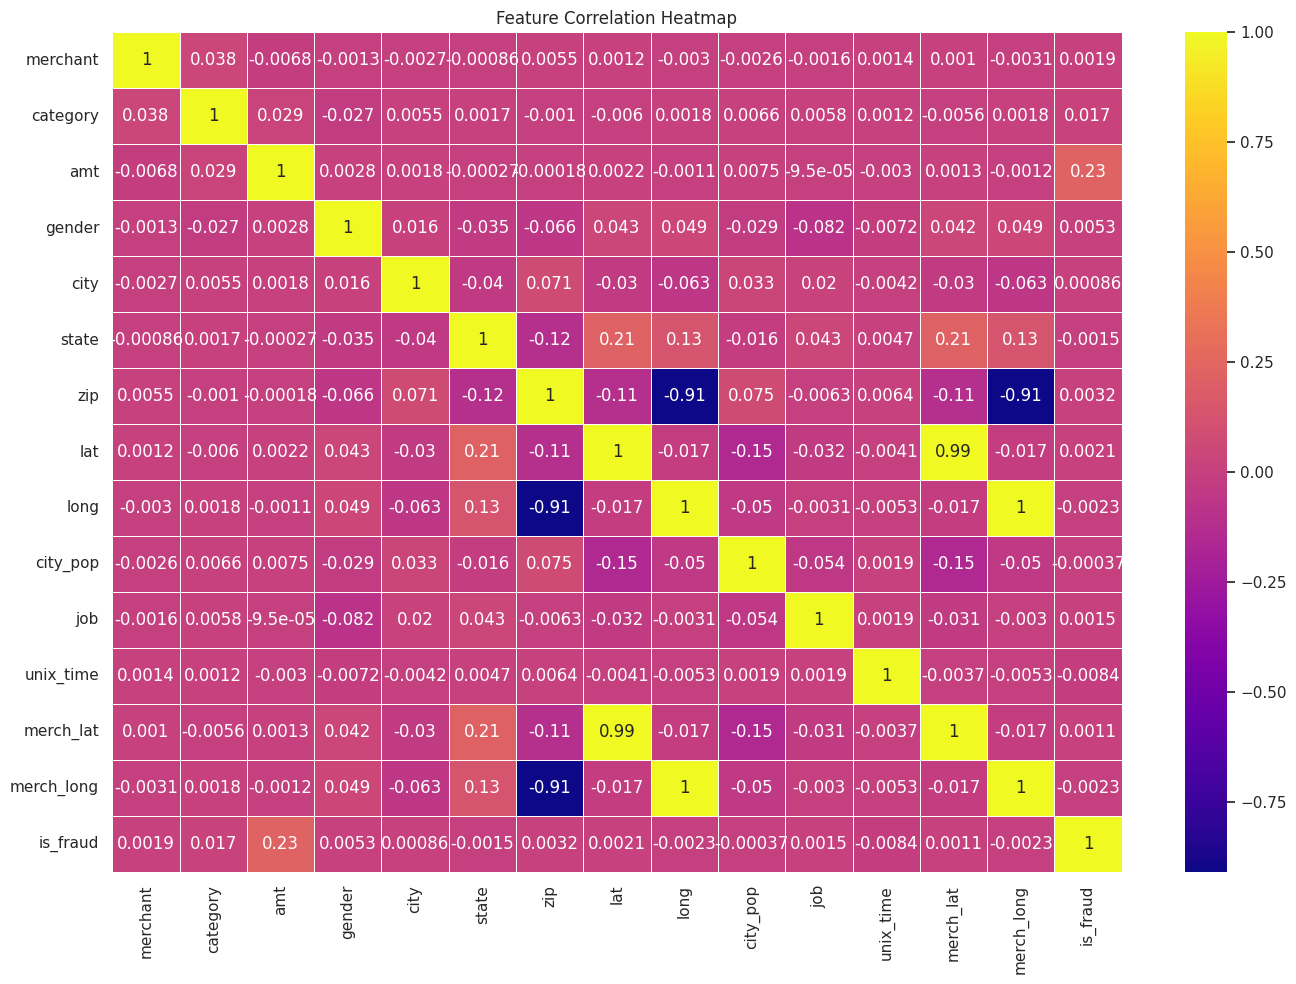

In [ ]:
plt.figure(figsize=(14, 10))
corr = df_scaled.drop(columns='category_name').corr()
sns.heatmap(corr, annot=True, cmap='plasma', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

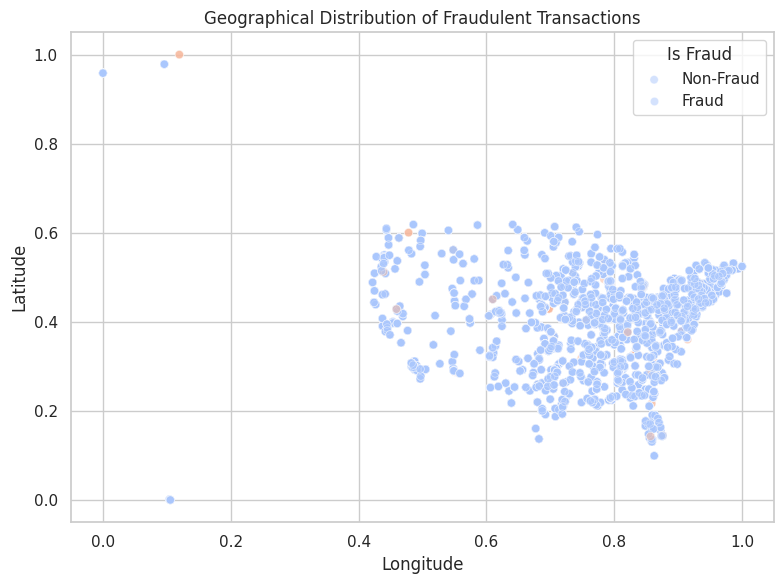

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='long', y='lat', hue='is_fraud', alpha=0.5, palette='coolwarm')
plt.title("Geographical Distribution of Fraudulent Transactions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Is Fraud', labels=['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

# Splitting the Dataset Into Training and Testing Sets, SMOTE Oversampling Method

In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_scaled.drop(['is_fraud', 'category_name'], axis=1)
y = df_scaled['is_fraud']

from imblearn.combine import SMOTETomek

# Apply SMOTE on the full dataset
smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Then split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

# Display the shape of the split
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target distribution:\n", y_train.value_counts(normalize=True))
print("Testing target distribution:\n", y_test.value_counts(normalize=True))

Training set shape: (159102, 14)
Testing set shape: (39776, 14)
Training target distribution:
 is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64
Testing target distribution:
 is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


# Model Training

## Train Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## 2. Train Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 3. Train Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Initialize and train
svm_model = make_pipeline(StandardScaler(), LinearSVC(random_state=42, max_iter=10000))
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(max_iter=10000, random_state=42))])

## 4. Train XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Dictionary to hold models
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "XGBoost": xgb_model
}

# Evaluation loop
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Predict class labels
    y_pred = model.predict(X_test)

    # Predict probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        # For LinearSVC or other models without predict_proba
        try:
            y_probs = model.decision_function(X_test)
        except:
            y_probs = y_pred  # fallback

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)

    # Print classification report and scores
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")


=== Logistic Regression ===
Classification Report:
               precision    recall  f1-score   support

           0     0.8083    0.9465    0.8720     19888
           1     0.9354    0.7756    0.8480     19888

    accuracy                         0.8610     39776
   macro avg     0.8719    0.8610    0.8600     39776
weighted avg     0.8719    0.8610    0.8600     39776

Precision: 0.9354
Recall:    0.7756
F1-Score:  0.8480
ROC-AUC:   0.9089

=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0     0.9991    0.9961    0.9976     19888
           1     0.9961    0.9991    0.9976     19888

    accuracy                         0.9976     39776
   macro avg     0.9976    0.9976    0.9976     39776
weighted avg     0.9976    0.9976    0.9976     39776

Precision: 0.9961
Recall:    0.9991
F1-Score:  0.9976
ROC-AUC:   1.0000

=== SVM ===
Classification Report:
               precision    recall  f1-score   support

          

# Hyperparameter Tuning

In [ ]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# XGBoost
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

In [ ]:
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
# Random Forest
best_rf = perform_grid_search(RandomForestClassifier(random_state=42), param_grid_rf, X_train, y_train)
print("Best Random Forest Params:", best_rf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# XGBoost
best_xgb = perform_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, X_train, y_train)
print("Best XGBoost Params:", best_xgb.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Dictionary to store models
best_models = {
    "Random Forest": best_rf.best_estimator_,
    "XGBoost": best_xgb.best_estimator_
}

# Evaluate each model
for name, model in best_models.items():
    print(f"\n=== {name} ===")

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")


=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     19888
           1       0.96      0.91      0.93     19888

    accuracy                           0.94     39776
   macro avg       0.94      0.94      0.94     39776
weighted avg       0.94      0.94      0.94     39776

Precision: 0.9623
Recall:    0.9066
F1-Score:  0.9336
ROC-AUC:   0.9900

=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19888
           1       0.99      0.98      0.99     19888

    accuracy                           0.99     39776
   macro avg       0.99      0.99      0.99     39776
weighted avg       0.99      0.99      0.99     39776

Precision: 0.9891
Recall:    0.9826
F1-Score:  0.9858
ROC-AUC:   0.9984


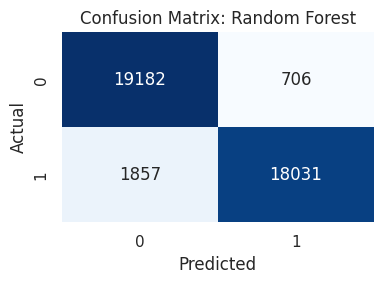

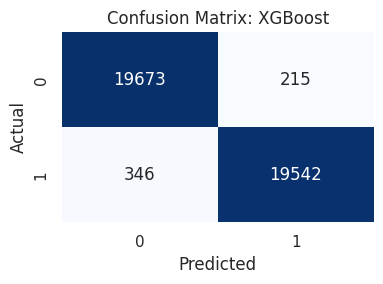

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrix
def plot_conf_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Dictionary of models
best_models = {
    "Random Forest": best_rf.best_estimator_,
    "XGBoost": best_xgb.best_estimator_
}

# Plot confusion matrix for each model
for name, model in best_models.items():
    plot_conf_matrix(model, X_test, y_test, name)

In [ ]:
# Extract the best estimator from GridSearchCV
xgb_best_model = best_xgb.best_estimator_

 99%|===================| 39525/39776 [01:59<00:00]       

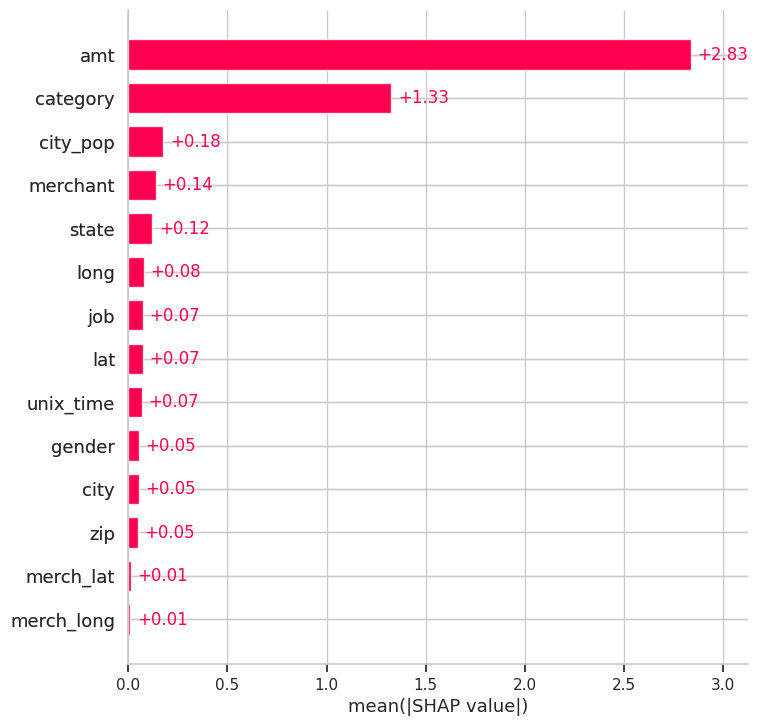

In [ ]:
import shap

# Ensure X_train is a DataFrame
explainer = shap.Explainer(xgb_best_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot the top 15 important features
shap.plots.bar(shap_values, max_display=15)

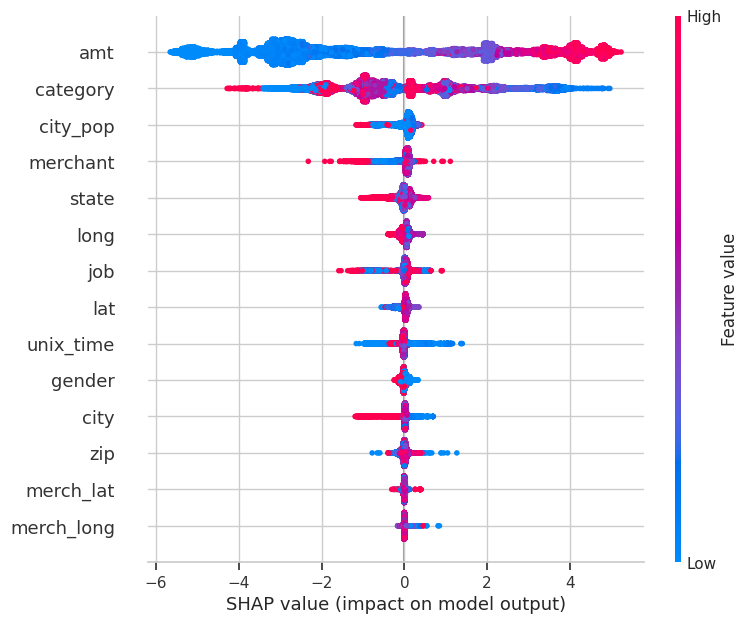

In [ ]:
# Beeswarm plot shows feature importance + directionality
shap.plots.beeswarm(shap_values, max_display=15)

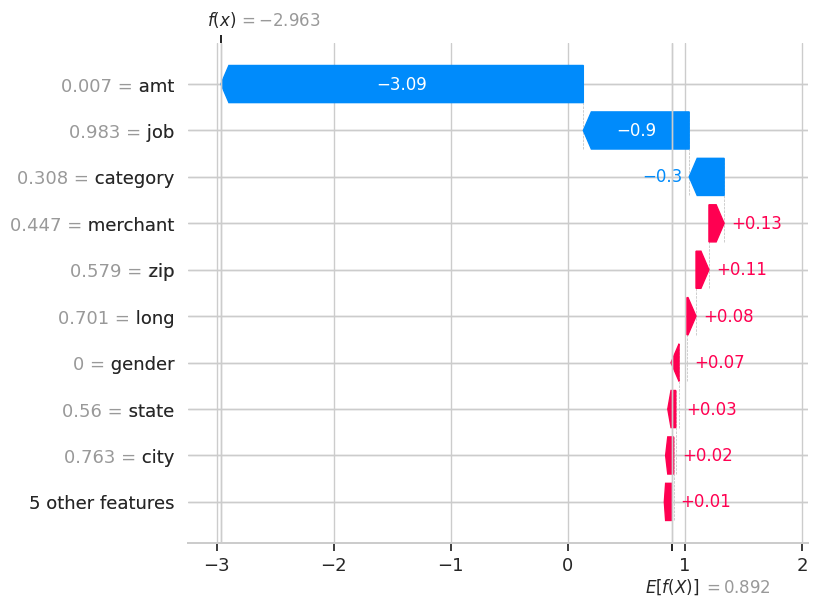

In [ ]:
# Explain a single instance (e.g., index 0)
shap.plots.waterfall(shap_values[0])

In [ ]:
import joblib

# Save model to file
joblib.dump(best_xgb.best_estimator_, "xgboost_model.pkl")

['xgboost_model.pkl']